# Game Of Life map generation

In [130]:
from matplotlib import pyplot as plt
import numpy as np

In [131]:
ON = 1  #0.6 probability
OFF = 0 #0.4 probability

vals = [ON, OFF]
rng = np.random.default_rng(12345)
 
def randomGrid(N):
    return rng.choice(vals, N*N, p=[0.6, 0.4]).reshape(N, N)

def update(grid, N):
    # N is map size, assuming that dimensions are N x N

    # copy grid since we require 8 neighbors
    # for calculation and we go line by line
    newGrid = grid.copy()
    for i in range(N):
        for j in range(N):
 
            # compute 8-neighbor sum
            # using toroidal boundary conditions - x and y wrap around
            # so that the simulation takes place on a toroidal surface.
            total = int((grid[i, (j-1)%N] + grid[i, (j+1)%N] +
                         grid[(i-1)%N, j] + grid[(i+1)%N, j] +
                         grid[(i-1)%N, (j-1)%N] + grid[(i-1)%N, (j+1)%N] +
                         grid[(i+1)%N, (j-1)%N] + grid[(i+1)%N, (j+1)%N]))
 
            # apply Conway's rules
            if grid[i, j]  == ON:
                if (total < 2) or (total > 3):
                    newGrid[i, j] = OFF
            else:
                if total == 3:
                    newGrid[i, j] = ON
                    
    return newGrid

def runGOL():     
    # set grid size
    N = 100
         
    # set animation update interval
    totalTimeSteps = 200
 
    # declare grid
    grid = np.array([])

    grid = randomGrid(N)

    for i in range(totalTimeSteps):
        grid[:] = update(grid, N)[:]
 
    return grid


In [132]:
CLR_MAP = {
    0: (0, 0, 0),  # black, wall
    1: (255, 255, 255),  # white, space/path
}

# initialize map
map_height = 100
map_width = map_height

# * height is y, width is x
# * so map_np[y,x]
# * origin point is at top left

# Generate map
init_map_np = runGOL()

# border walls
# top
init_map_np[0, :] = 1
# bottom
init_map_np[map_height - 1, :] = 1
# left
init_map_np[:, 0] = 1
# right
init_map_np[:, map_width - 1] = 1

# Remove walls in snake's starting position
start_position_area_y = range(2,16)
start_position_area_x = range(2,9)


for y in start_position_area_y:
    for x in start_position_area_x:
        init_map_np[y,x] = 0

map_np = init_map_np.copy()

print(map_np)

[[1 1 1 ... 1 1 1]
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 1]
 ...
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 1]
 [1 1 1 ... 1 1 1]]


## Define utility functions/ classes

In [133]:
#For storage later
class Coordinates:
    def __init__(self, y, x):
        self.y = y
        self.x = x

def findWallCoordinates(map_np):
    wallCoordinates = []

    for y in range(1,map_np.shape[0]-1):
        for x in range(1,map_np.shape[1]-1):
            if map_np[y,x] == ON:
                wallCoordinates.append(Coordinates(y,x))

    return wallCoordinates

def getCardinalCoordinates(map_np, coordinate):
    #Attempt to get the cardinal coordinates so long as they aren't boundaries/walls
    cardinalCoordinates = {}
    x = coordinate.x
    y = coordinate.y
    #Get left:
    if x != 1 and map_np[y,x-1] != 1:
            cardinalCoordinates["left"] = Coordinates(y,x-1) 
    #Get right:
    if x != map_np.shape[1]-2 and map_np[y,x+1] != 1:
        cardinalCoordinates["right"] = Coordinates(y,x+1)
    #Get top:
    if y != 1 and map_np[y-1,x] != 1:
        cardinalCoordinates["top"] = Coordinates(y-1,x)
    #Get bottom:
    if y != map_np.shape[0]-2 and map_np[y+1,x] != 1:
        cardinalCoordinates["bottom"] = Coordinates(y+1,x)
    return cardinalCoordinates

def getNonCardinalCoordinates(map_np, coordinate):
    #Attempt to get the NonCardinal coordinates so long as they aren't boundaries 
    #AND IF THEY "ARE" (not aren't) WALLS <--- VERY IMPORTANT
    nonCardinalCoordinates = {}
    x = coordinate.x
    y = coordinate.y
    #Get top-left:
    if x != 1 and y != 1 and map_np[y-1,x-1] == 1:
        nonCardinalCoordinates["topLeft"] = Coordinates(y-1,x-1)
    #Get top-right:
    if x != map_np.shape[1]-2 and y != 1 and map_np[y-1,x+1] == 1:
        nonCardinalCoordinates["topRight"] = Coordinates(y-1,x+1)
    #Get bottom-left:
    if y != map_np.shape[0]-2 and x != 1 and map_np[y+1,x-1] == 1:
        nonCardinalCoordinates["bottomLeft"] = Coordinates(y+1,x-1)
    #Get bottom-right:
    if y != map_np.shape[0]-2 and x != map_np.shape[1]-2 and map_np[y+1,x+1] == 1:
        nonCardinalCoordinates["bottomRight"] = Coordinates(y+1,x+1)
    return nonCardinalCoordinates

In [134]:
def recurseFill(map_np, coordinate):
    cardinalDict = getCardinalCoordinates(map_np, coordinate)
    nonCardindalDict = getNonCardinalCoordinates(map_np, coordinate)

    #Gonna ignore top for now, 
    #since we process the map from top to bottom, 
    #we probably cover top cases ard

    #If right, we'll check top right and btm right
    if "right" in cardinalDict:
        if "topRight" in nonCardindalDict or "bottomRight" in nonCardindalDict:
            #Fill/Convert into wall
            map_np[cardinalDict["right"].y, cardinalDict["right"].x] = 1
            recurseFill(map_np, cardinalDict["right"])

    #If bottom, we'll check bottom left and bottom right
    if "bottom" in cardinalDict:
        if "bottomLeft" in nonCardindalDict or "bottomRight" in nonCardindalDict:
            #Fill/Convert into wall
            map_np[cardinalDict["bottom"].y, cardinalDict["bottom"].x] = 1
            recurseFill(map_np, cardinalDict["bottom"])

    #If left, we'll check top left and bottom left
    if "left" in cardinalDict:
        if "bottomLeft" in nonCardindalDict or "topLeft" in nonCardindalDict:
            #Fill/Convert into wall
            map_np[cardinalDict["left"].y, cardinalDict["left"].x] = 1
            recurseFill(map_np, cardinalDict["left"])

# Fill up the map

In [135]:
wallCoordinates = findWallCoordinates(map_np)

for coordinate in wallCoordinates:
    recurseFill(map_np, coordinate)


# Plot the map

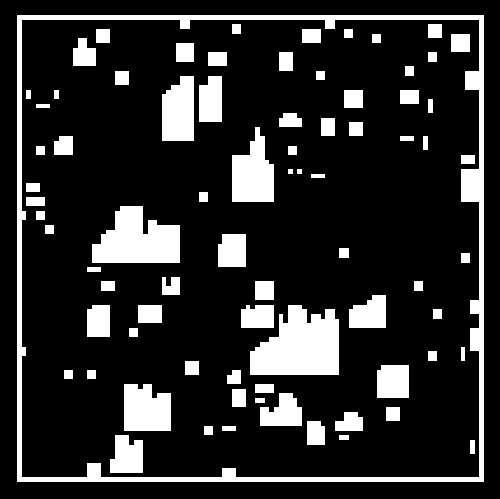

In [136]:
# convert to RGB Map
color_map_np = np.zeros((map_np.shape[0], map_np.shape[1], 3), dtype=np.uint8)

for y in range(map_np.shape[0]):
    for x in range(map_np.shape[1]):
        color = CLR_MAP[map_np[y, x]]
        color_map_np[y, x] = np.array(color)

plt.figure(facecolor='black')
plt.tight_layout()
plt.axis("off")   # turns off axes
plt.axis("tight")  # gets rid of white border
plt.axis("image")  # square up the image instead of filling the "figure" space
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.xlim([-2, map_width + 1])
plt.ylim([map_height + 1, -2])
plt.imshow(color_map_np, interpolation='nearest')
# plt.gcf().set_dpi(300)
# plt.savefig("test.png",bbox_inches='tight')
plt.show()

In [137]:
# output map
# Writing to file
with open("./map/dummy_map.txt", "w") as file:
    # Writing data to a file
    for y in range(map_np.shape[0]):
        # print(''.join(map(str,map_np[y, :].tolist())))
        file.write(''.join(map(str,map_np[y, :].tolist()))+'\n')


In [138]:
with open("./map/dummy_map.txt") as f:
    lines = f.readlines()
# check height & width
map_height = len(lines)
map_width = len(lines[0].strip())
map_repr = [ [0]*map_width for _ in range(map_height) ]
print(f"map_height: {map_height}")
print(f"map_width: {map_width }")

for y in range(len(lines)):
    line = lines[y].strip()
    for x in range(len(line)):
        map_repr[y][x] = int(line[x])

print(map_repr)


map_height: 100
map_width: 100
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0